In [1]:
"""
From
https://www.tensorflow.org/tutorials/audio/simple_audio
"""

'\nFrom\nhttps://www.tensorflow.org/tutorials/audio/simple_audio\n'

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-06-22 22:17:03.238624: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import string

class_names = [x for x in string.ascii_lowercase]
class_names = class_names + [str(x) for x in range(0, 10, 1)]

In [4]:
data_dir = pathlib.Path("./training_data")

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/class_names[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 497
Number of examples per label: 16
Example file tensor: tf.Tensor(b'training_data/x/7.wav', shape=(), dtype=string)


2022-06-22 22:17:03.977743: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-22 22:17:04.830904: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-22 22:17:04.830949: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: flagship
2022-06-22 22:17:04.830955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: flagship
2022-06-22 22:17:04.831127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-22 22:17:04.831161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-22 22:17:04.831170: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- c

In [5]:
train_files = filenames[:int(500 * 0.8)]
val_files = filenames[int(500 * 0.8): int(500 * 0.9)]
test_files = filenames[int(500 * 0.9):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 400
Validation set size 50
Test set size 47


In [6]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

In [8]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [10]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [11]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: x
Waveform shape: (4894,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [12]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

/tmp/ipykernel_481787/380151291.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


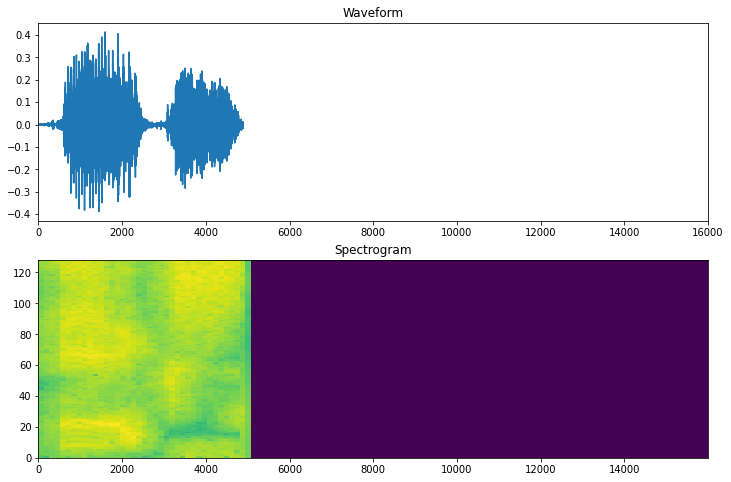

In [13]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [14]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.math.argmax(label == class_names)
    return spectrogram, label_id

In [15]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

/tmp/ipykernel_481787/380151291.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


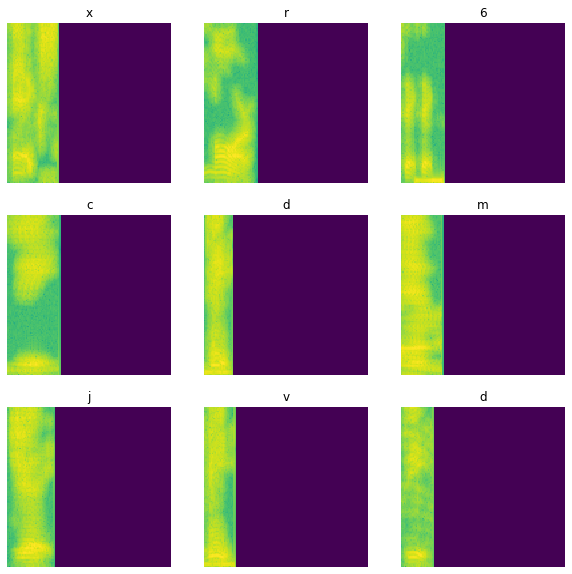

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(class_names[label_id.numpy()])
    ax.axis('off')

plt.show()

In [17]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [18]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [19]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [20]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [21]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(class_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.experimental.preprocessing.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
7/7 [==============================] - 0s 52ms/step - loss: 3.2609 - accuracy: 0.1125 - val_loss: 2.5772 - val_accuracy: 0.2800
Epoch 2/10
7/7 [==============================] - 0s 29ms/step - loss: 2.3414 - accuracy: 0.3700 - val_loss: 1.8128 - val_accuracy: 0.4800
Epoch 3/10
7/7 [==============================] - 0s 30ms/step - loss: 1.8518 - accuracy: 0.5000 - val_loss: 1.2622 - val_accuracy: 0.6800
Epoch 4/10
7/7 [==============================] - 0s 28ms/step - loss: 1.4138 - accuracy: 0.5925 - val_loss: 0.9256 - val_accuracy: 0.8000
Epoch 5/10
7/7 [==============================] - 0s 29ms/step - loss: 1.1710 - accuracy: 0.6575 - val_loss: 0.7255 - val_accuracy: 0.8600
Epoch 6/10
7/7 [==============================] - 0s 32ms/step - loss: 0.8668 - accuracy: 0.7475 - val_loss: 0.5595 - val_accuracy: 0.8400
Epoch 7/10
7/7 [==============================] - 0s 29ms/step - loss: 0.8167 - accuracy: 0.7600 - val_loss: 0.4409 - val_accuracy: 0.9000
Epoch 8/10
7/7 [===========

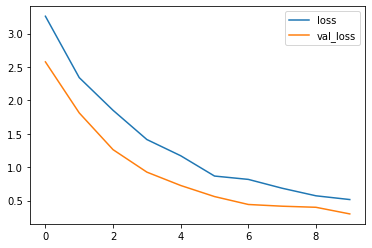

In [24]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [26]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 89%


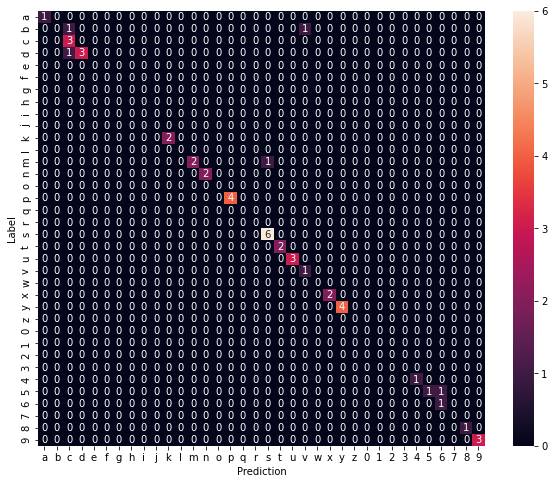

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
!mkdir -p saved_model

model.save('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-06-22 22:17:12.592246: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [117]:
from IPython.display import Audio 
Audio("./test/captcha_f1507495a5414d16976355ea1adb2610.wav", autoplay=True)

In [142]:
from pydub import AudioSegment

new_audio = AudioSegment.from_wav("./test/captcha_f83e7a6d91d94c5cafa7b8aabedd2098.wav",)
start = 1.3 * 1000
end = 1.* 1000
tmp_audio = new_audio[start:end]
tmp_audio.export("test.wav", format="wav")

<_io.BufferedRandom name='test.wav'>

In [143]:
from IPython.display import Audio 
Audio("./test.wav", autoplay=True)

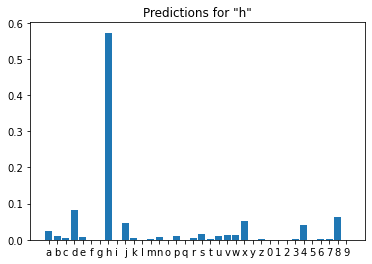

In [144]:
sample_file = "./test.wav"

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    result = tf.nn.softmax(prediction[0]).numpy()
    list_result = result.tolist()
    max_val = max(result)
    max_val_index = list_result.index(max_val)
    
    class_label = class_names[max_val_index]
    
    plt.bar(class_names, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{class_label}"')
    
    plt.show()